In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

from datetime import date

In [107]:
#Скачивание ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

In [108]:
#Преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True).dt.strftime('%d.%m.%Y')

#Перенаименование столбцов
df.columns = ['date', 'key_rate']

In [109]:
#Общая информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      2609 non-null   object 
 1   key_rate  2609 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.9+ KB


In [110]:
#Jсновные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2609.000000
mean,8.635397
std,3.104487
min,4.250000
25%,7.000000
50%,7.750000
75%,10.000000
max,20.000000


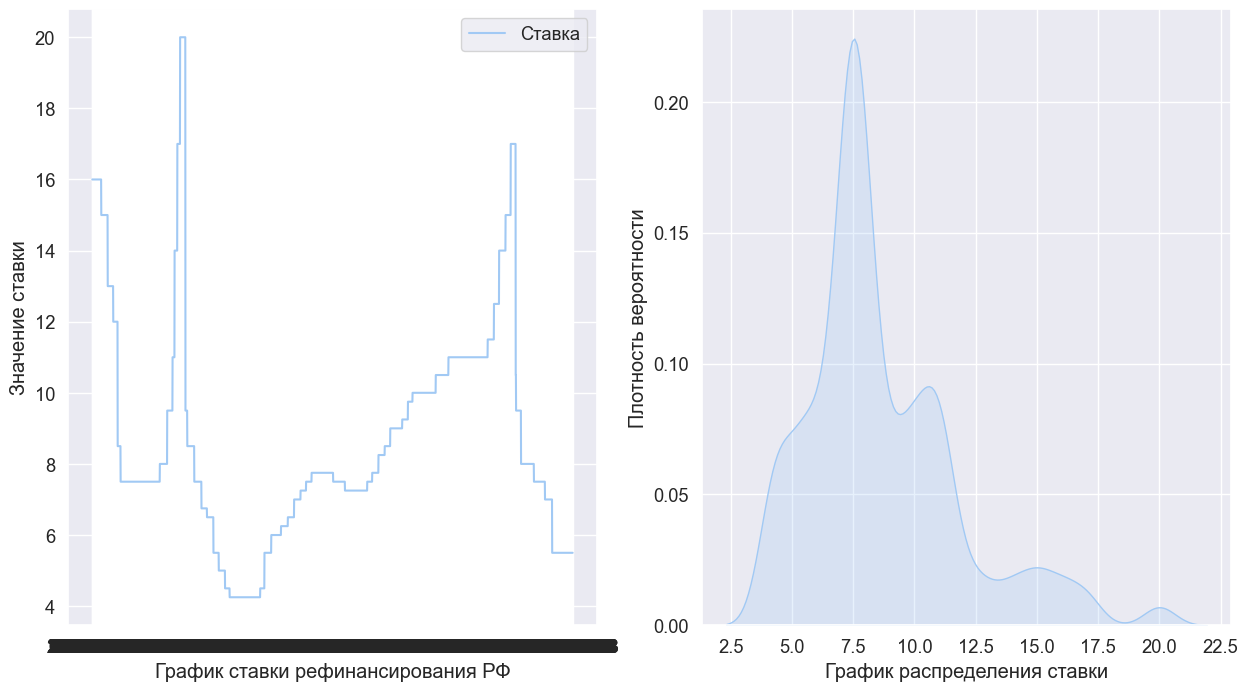

In [111]:
figure, axes = plt.subplots(1, 2, figsize=(15, 8))

sns.set_theme(style="darkgrid", palette="pastel", font_scale=1.2)

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=axes[0])
axes[0].set_xlabel('График ставки рефинансирования РФ')
axes[0].set_ylabel('Значение ставки')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=axes[1], fill=True)
axes[1].grid(True)
axes[1].set_xlabel('График распределения ставки')
axes[1].set_ylabel('Плотность вероятности')
plt.show()